### Installing the latest version of fastai library's search function for duckduckgo

In [1]:
!pip install -Uqq fastai duckduckgo_search

In [9]:
from fastbook import *
from fastai.vision.widgets import *

ImportError: cannot import name 'search_images_ddg' from 'duckduckgo_search' (c:\Users\Asus\anaconda3\lib\site-packages\duckduckgo_search\__init__.py)

### The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"

2. Use DuckDuckGo to search for images of "forest photos"

3. Fine-tune a pretrained neural network to recognise these two groups

4. Try running this model on a picture of a bird and see if it works.

In [10]:
urls = search_images_ddg('bird photos', max_images=1)

In [11]:
urls[0]

'https://www.wallpapers13.com/wp-content/uploads/2016/07/Beautiful-colorful-birds-on-a-branch-Desktop-Wallpaper-HD-free-download2560x1600-1920x1440.jpg'

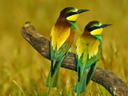

In [12]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress = False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(128,128)

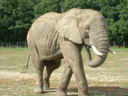

In [15]:
download_url(search_images_ddg('elephant', max_images=1)[0], 'elephant.jpg', show_progress = False)
Image.open('elephant.jpg').to_thumb(128,128)


In [20]:
searches = 'bird', 'elephant', 'tiger', 'giraffe', 'wolf', 'bear', 'lion', 'zebra', 'gorilla', 'monkey'
path = Path('animals')
from time import sleep

for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents = True)
    download_images(dest,urls=search_images_ddg( f'{o} photos', max_images=100))
    sleep(10)
    resize_images(path/o, max_size = 400, dest = path/o)
    

### Step 2: Train our model

In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

16

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

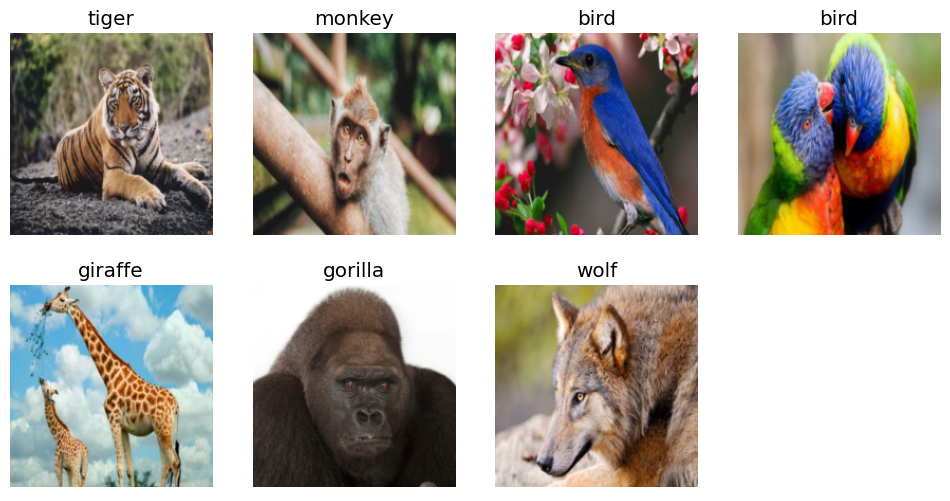

In [25]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock)
    ,get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=[Resize(192, method = 'squish')]

).dataloaders(path, bs = 32)

dls.show_batch(max_n=7)

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files, 

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.


In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

c:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.416649,0.047335,0.005435,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.122359,0.039356,0.005435,01:00
1,0.081674,0.031064,0.005435,00:56
2,0.055740,0.032262,0.010870,00:55


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the free fast.ai course.

In [29]:
is_bird,_, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"Is this a bird?: {is_bird}.")
print(f"Probability it's a bird: {probs[1].item():.6f}")

Is this a bird?: bird.
Probability it's a bird: 0.999973


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including creating amazing artworks, and explaining jokes. It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

In [31]:
learn.export()